<a href="https://colab.research.google.com/github/DarwinAndrey/Senales_y_sistemas/blob/main/Parcial_1_SyS_2025_01_Darwin_Andrey_Arias_Garcia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

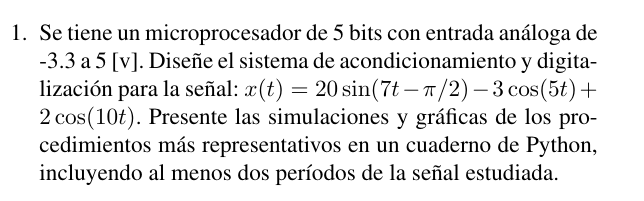

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.spatial.distance import cdist
import sympy as sp  # Importamos SymPy para trabajar con álgebra simbólica
import matplotlib.pyplot as plt # Importamos matplotlib para graficar (opcional para visualización)

Frecuencia máxima (f_max): 1.59 Hz
Frecuencia de muestreo seleccionada (fs): 15.92 Hz
Período de muestreo (Ts): 0.0628 s
Valor mínimo de la señal original (utilizando rango teórico): -25.00 V
Valor máximo de la señal original (utilizando rango teórico): 25.00 V
Ganancia del sistema de acondicionamiento: 0.166
Offset del sistema de acondicionamiento: 0.850
Número de bits: 5
Número de niveles de cuantización: 32
Rango de entrada para cuantización: 8.30 V
Paso de cuantización: 0.2677 V


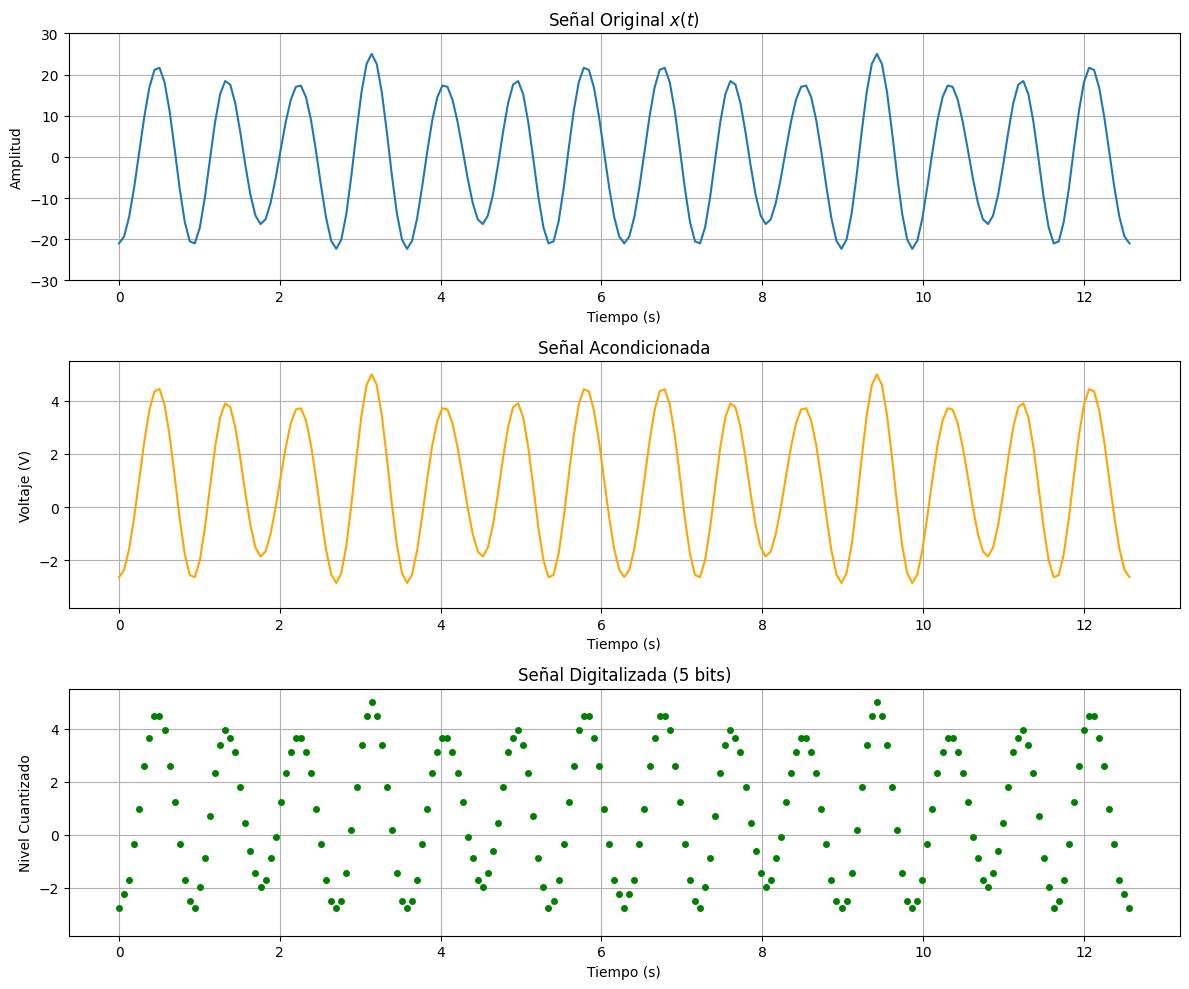

In [16]:
# %% [markdown]
# ### Diseño de Sistema de Acondicionamiento y Digitalización para una Señal Analógica
#
# Este cuaderno de Python implementa el diseño de un sistema de acondicionamiento y digitalización para una señal analógica específica, considerando las características de un microprocesador dado.
#
# **Problema:** Se tiene un microprocesador de 5 bits con entrada analógica de -3.3 a 5[V]. Diseñar el sistema de acondicionamiento y digitalización para la señal:
#
# $x(t) = 20\sin(7t - \pi/2) - 3\cos(5t) + 2\cos(10t)$.
#
# Presentar las simulaciones y gráficas de los procedimientos más representativos, incluyendo al menos dos períodos de la señal estudiada.
#
# **Consideración Adicional:** Se toma como dato que la señal original $x(t)$ tiene un rango de -25V a 25V.

# %% [markdown]
# ## 1. Definición de la Señal Original
#
# Definimos la función matemática que representa la señal analógica $x(t)$.
# %%
# Definir la señal original como una función de t
def x(t):
  return 20 * np.sin(7 * t - np.pi/2) - 3 * np.cos(5 * t) + 2 * np.cos(10 * t)

# Definir el rango teórico de la señal original según lo proporcionado
x_min_teorico = -25.0
x_max_teorico = 25.0

# %% [markdown]
# ## 2. Análisis de la Señal y Determinación de la Frecuencia de Muestreo
#
# Analizamos las componentes de frecuencia de la señal para determinar la frecuencia máxima y aplicar el teorema de Nyquist para evitar el aliasing.
# %%
# Análisis de la señal para determinar la frecuencia máxima
# Las frecuencias angulares (en rad/s) de las componentes sinusoidales son 7, 5 y 10.
# Las frecuencias en Hz son $\omega / (2\pi)$.
# f1 = 7 / (2 * np.pi) Hz
# f2 = 5 / (2 * np.pi) Hz
# f3 = 10 / (2 * np.pi) Hz
# La frecuencia más alta presente en la señal es f_max = 10 / (2 * np.pi) Hz.

f_max = 10 / (2 * np.pi)

# Según el teorema de Nyquist, la frecuencia de muestreo (fs) debe ser mayor que el doble de la frecuencia máxima (fs > 2 * f_max) para evitar aliasing.
# Se recomienda una frecuencia de muestreo significativamente superior a la de Nyquist para asegurar una buena reconstrucción de la señal.
# Aquí, tomamos una frecuencia de muestreo 10 veces mayor que la frecuencia máxima.
fs = 10 * f_max
Ts = 1 / fs # Cálculo del período de muestreo (Ts = 1/fs)

print(f"Frecuencia máxima (f_max): {f_max:.2f} Hz")
print(f"Frecuencia de muestreo seleccionada (fs): {fs:.2f} Hz")
print(f"Período de muestreo (Ts): {Ts:.4f} s")

# %% [markdown]
# ## 3. Diseño del Sistema de Acondicionamiento (Utilizando Rango Teórico Dado)
#
# El sistema de acondicionamiento escala y desplaza la señal original (con un rango dado de -25V a 25V) para que se ajuste al rango de entrada analógica del microprocesador (-3.3V a 5V). Esto implica calcular la ganancia y un offset basados en estos rangos conocidos.
# %%
# Especificaciones del rango de entrada analógica del microprocesador
entrada_min = -3.3  # Valor mínimo de voltaje de entrada
entrada_max = 5.0   # Valor máximo de voltaje de entrada

# Rango de la señal original (utilizamos el rango teórico dado)
x_min = x_min_teorico
x_max = x_max_teorico

print(f"Valor mínimo de la señal original (utilizando rango teórico): {x_min:.2f} V")
print(f"Valor máximo de la señal original (utilizando rango teórico): {x_max:.2f} V")

# Calculamos la ganancia (m) y el offset (c) del sistema de acondicionamiento.
# Queremos mapear el rango [x_min, x_max] al rango [entrada_min, entrada_max].
# La relación es lineal: señal_acondicionada = ganancia * señal_original + offset
# Tenemos un sistema de dos ecuaciones:
# 1) entrada_min = ganancia * x_min + offset
# 2) entrada_max = ganancia * x_max + offset

# Resolviendo el sistema de ecuaciones para ganancia y offset:
ganancia = (entrada_max - entrada_min) / (x_max - x_min)
offset = entrada_min - ganancia * x_min

print(f"Ganancia del sistema de acondicionamiento: {ganancia:.3f}")
print(f"Offset del sistema de acondicionamiento: {offset:.3f}")

# Definimos la función que aplica el acondicionamiento a la señal con la ganancia y offset calculados.
def acondicionar_senal(senal):
  return ganancia * senal + offset

# %% [markdown]
# ## 4. Diseño del Sistema de Digitalización (Cuantización)
#
# El sistema de digitalización convierte la señal analógica acondicionada en un conjunto discreto de valores, limitados por el número de bits del microprocesador.
# %%
# Número de bits del microprocesador, que determina el número de niveles de cuantización.
nbits = 5
niveles_cuantizacion = 2**nbits # Número total de niveles de cuantización (2^nbits)

# El rango de entrada para la cuantización es el mismo que el rango de entrada del microprocesador.
rango_entrada_cuantizacion = entrada_max - entrada_min

# Calculamos el tamaño del paso de cuantización.
# Si incluimos tanto entrada_min como entrada_max como niveles posibles, hay (niveles_cuantizacion - 1) intervalos.
paso_cuantizacion = rango_entrada_cuantizacion / (niveles_cuantizacion - 1)

print(f"Número de bits: {nbits}")
print(f"Número de niveles de cuantización: {niveles_cuantizacion}")
print(f"Rango de entrada para cuantización: {rango_entrada_cuantizacion:.2f} V")
print(f"Paso de cuantización: {paso_cuantizacion:.4f} V")

# Definimos la función que cuantiza la señal acondicionada.
def cuantizar_senal(senal_acondicionada):
  # Primero, nos aseguramos de que la señal acondicionada esté dentro del rango de entrada del microprocesador.
  # Esto evita que valores fuera del rango se cuantifiquen incorrectamente.
  senal_limitada = np.clip(senal_acondicionada, entrada_min, entrada_max)

  # Calculamos los índices de cuantización. Estos índices representan a qué nivel de cuantización se asigna cada valor.
  # Se resta el valor mínimo de entrada y se divide por el paso de cuantización.
  # np.round() redondea al entero más cercano, asignando el valor al nivel más cercano.
  indices = np.round((senal_limitada - entrada_min) / paso_cuantizacion)

  # Calculamos los valores cuantizados multiplicando el índice por el paso de cuantización y sumando el valor mínimo de entrada.
  # Aseguramos que los valores cuantizados estén dentro del rango de entrada del microprocesador.
  senal_cuantizada = entrada_min + indices * paso_cuantizacion
  senal_cuantizada = np.clip(senal_cuantizada, entrada_min, entrada_max) # Doble verificación para asegurar

  return senal_cuantizada

# %% [markdown]
# ## 5. Simulación y Graficación de los Resultados
#
# Simulamos el proceso completo generando las señales original, acondicionada y digitalizada en un intervalo de tiempo que incluye al menos dos períodos de la señal original. Luego, graficamos estas señales para visualizar el efecto del acondicionamiento y la digitalización.
# %%
# Definimos el rango de tiempo para la simulación.
# Para capturar el comportamiento completo de la señal, simulamos al menos dos períodos.
# El período de la señal x(t) es el mínimo común múltiplo de los períodos de sus componentes sinusoidales.
# Períodos de las componentes: T1 = 2pi/7, T2 = 2pi/5, T3 = 2pi/10.
# El mínimo común múltiplo de los denominadores de las frecuencias angulares (7, 5, 10) es 70.
# El período de la señal x(t) es Periodo = 2pi * mcm(1/7, 1/5, 1/10) = 2pi * (70 / mcm(7, 5, 10)) = 2pi * (70/70) = 2pi.
periodo_senal = 2 * np.pi

# Creamos un vector de tiempo utilizando np.arange con el período de muestreo (Ts).
# Simulamos durante dos períodos de la señal original.
t = np.arange(0, 2 * periodo_senal, Ts) # Vector de tiempo discreto

# Calculamos los valores de las señales en los puntos de tiempo definidos.
# Usamos la señal original x(t) para la simulación. El acondicionamiento la mapeará al rango del microprocesador.
senal_original = x(t) # Señal original en los puntos de muestreo
senal_acondicionada = acondicionar_senal(senal_original) # Señal después del acondicionamiento (ahora mapeada de -25 a 25 a -3.3 a 5)
senal_digitalizada = cuantizar_senal(senal_acondicionada) # Señal después de la digitalización (cuantizada a 5 bits dentro del rango -3.3 a 5)

# Graficamos los resultados para visualizar cada etapa del proceso.
plt.figure(figsize=(12, 10)) # Establece el tamaño de la figura para las gráficas

# Gráfica de la Señal Original
plt.subplot(3, 1, 1) # Crea el primer subplot en una cuadrícula de 3 filas y 1 columna
plt.plot(t, senal_original) # Grafica la señal original en función del tiempo
plt.title('Señal Original $x(t)$') # Título del subplot
plt.xlabel('Tiempo (s)') # Etiqueta del eje x
plt.ylabel('Amplitud') # Etiqueta del eje y
plt.grid(True) # Muestra la cuadrícula
plt.ylim(x_min_teorico - 5, x_max_teorico + 5) # Ajusta los límites del eje y para mostrar el rango teórico

# Gráfica de la Señal Acondicionada
plt.subplot(3, 1, 2) # Crea el segundo subplot
plt.plot(t, senal_acondicionada, color='orange') # Grafica la señal acondicionada
plt.title('Señal Acondicionada') # Título del subplot
plt.xlabel('Tiempo (s)') # Etiqueta del eje x
plt.ylabel('Voltaje (V)') # Etiqueta del eje y
plt.grid(True) # Muestra la cuadrícula
plt.ylim(entrada_min - 0.5, entrada_max + 0.5) # Ajusta los límites del eje y para visualizar mejor el rango de entrada del microprocesador

# Gráfica de la Señal Digitalizada (Cuantizada)
plt.subplot(3, 1, 3) # Crea el tercer subplot
# Grafica la señal digitalizada usando puntos (marker='o') sin líneas (linestyle='None')
plt.plot(t, senal_digitalizada, color='green', marker='o', linestyle='None', markersize=4)
plt.title('Señal Digitalizada (5 bits)') # Título del subplot
plt.xlabel('Tiempo (s)') # Etiqueta del eje x
plt.ylabel('Nivel Cuantizado') # Etiqueta del eje y
plt.grid(True) # Muestra la cuadrícula
plt.ylim(entrada_min - 0.5, entrada_max + 0.5) # Ajusta los límites del eje y para visualizar los niveles cuantizados dentro del rango del microprocesador

plt.tight_layout() # Ajusta automáticamente los parámetros del subplot para evitar superposiciones
plt.show()

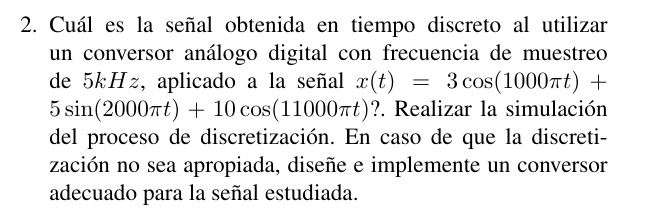

Frecuencias originales de las componentes: [ 500. 1000. 5500.] Hz
Frecuencia máxima de la señal (f_max): 5499.999999999999 Hz
Frecuencia de muestreo dada (fs_dada): 5000 Hz
Frecuencia de Nyquist (f_nyquist): 10999.999999999998 Hz
La frecuencia de muestreo dada NO ES SUFICIENTE para evitar aliasing.
Se producirá aliasing para las componentes con frecuencias mayores a fs_dada / 2 (2500.0 Hz).

Frecuencia máxima representable sin aliasing con fs=5000 Hz: 2500.0 Hz

Cálculo de las frecuencias alias para cada componente original:
Frecuencia original: 499.99999999999994 Hz --> Frecuencia alias: 499.99999999999994 Hz
Frecuencia original: 999.9999999999999 Hz --> Frecuencia alias: 999.9999999999999 Hz
Frecuencia original: 5499.999999999999 Hz --> Frecuencia alias: 499.9999999999991 Hz
Expresión teórica de la señal obtenida en tiempo discreto con aliasing:
x_discreta_aliased[n] = 13*cos(pi/5 * n) + 5*sin(2*pi/5 * n)


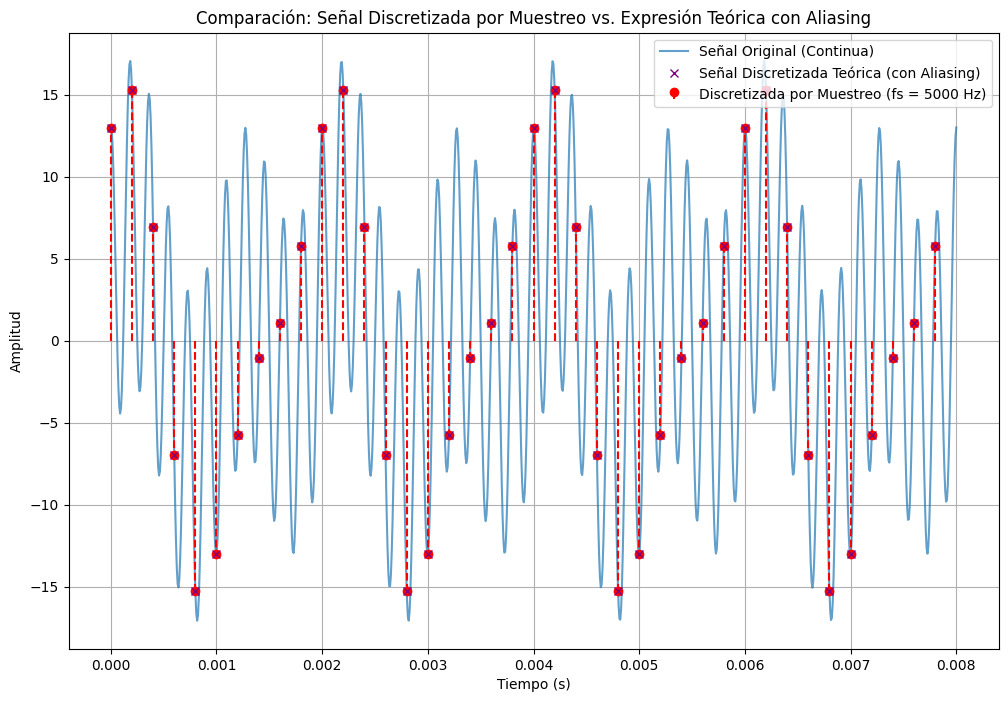


Diferencia máxima entre la señal discretizada por muestreo y la teórica: 5.62e-13
Los valores de la señal discretizada por muestreo y la teórica coinciden (dentro de la tolerancia).

Diseñando e implementando un conversor adecuado:
Frecuencia de muestreo adecuada (fs_adecuada): 12100.00 Hz (Mayor que Nyquist)
Período de muestreo adecuado (Ts_adecuada): 0.0001 s


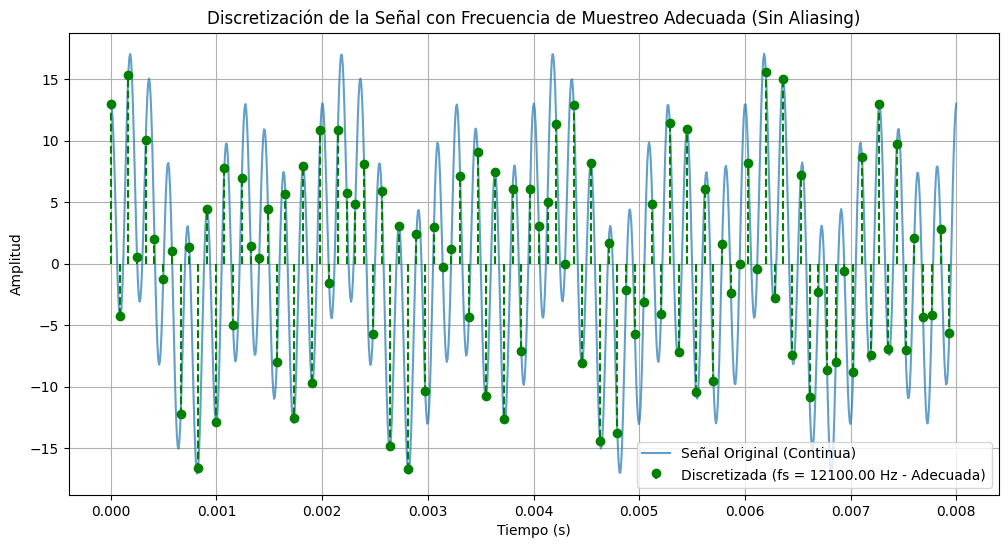

In [22]:
# %% [markdown]
# ### Punto 2: Discretización de una Señal Analógica y Análisis de Aliasing
#
# Este apartado aborda la discretización de la señal $x(t) = 3\cos(1000\pi t) + 5\sin(2000\pi t) + 10\cos(11000\pi t)$ utilizando una frecuencia de muestreo específica (5kHz) y analiza el fenómeno del aliasing.

# %% [markdown]
# ## 1. Definición de la Nueva Señal Original
#
# Definimos la función matemática que representa la señal analógica $x(t)$ para este segundo punto.
# %%
# Definir la señal original como una función de t para el Punto 2
def x_punto2(t):
  return 3 * np.cos(1000 * np.pi * t) + 5 * np.sin(2000 * np.pi * t) + 10 * np.cos(11000 * np.pi * t)

# %% [markdown]
# ## 2. Análisis de la Señal para el Punto 2
#
# Analizamos las componentes de frecuencia de esta nueva señal para identificar las frecuencias originales.
# %%
# Análisis de la señal para determinar las frecuencias de las componentes en el Punto 2
# Las frecuencias angulares (en rad/s) de las componentes son 1000*pi, 2000*pi, y 11000*pi.
# Calculamos las frecuencias en Hz (f = omega / (2*pi)):
f1_original = (1000 * np.pi) / (2 * np.pi)
f2_original = (2000 * np.pi) / (2 * np.pi)
f3_original = (11000 * np.pi) / (2 * np.pi)

f_originales = np.array([f1_original, f2_original, f3_original])

print(f"Frecuencias originales de las componentes: {f_originales} Hz")

# Determinamos la frecuencia máxima presente en la señal.
f_max_punto2 = np.max(f_originales)
print(f"Frecuencia máxima de la señal (f_max): {f_max_punto2} Hz")


# %% [markdown]
# ## 3. Análisis de la Frecuencia de Muestreo Dada y el Aliasing
#
# Analizamos la frecuencia de muestreo proporcionada (5kHz) y calculamos las frecuencias a las que se "pliegan" (alias) las componentes de la señal original debido a esta frecuencia de muestreo insuficiente.
# %%
# Frecuencia de muestreo proporcionada en el problema
fs_dada = 5000  # Hz (5 kHz)

# Calculamos la frecuencia de Nyquist, que es el doble de la frecuencia máxima de la señal.
f_nyquist = 2 * f_max_punto2

print(f"Frecuencia de muestreo dada (fs_dada): {fs_dada} Hz")
print(f"Frecuencia de Nyquist (f_nyquist): {f_nyquist} Hz")

# Verificamos si la frecuencia de muestreo dada cumple el teorema de Nyquist (fs > f_nyquist).
if fs_dada > f_nyquist:
  print("La frecuencia de muestreo dada ES SUFICIENTE para evitar aliasing.")
else:
  print("La frecuencia de muestreo dada NO ES SUFICIENTE para evitar aliasing.")
  print(f"Se producirá aliasing para las componentes con frecuencias mayores a fs_dada / 2 ({fs_dada/2} Hz).")

# Calculamos las frecuencias a las que se "pliegan" (alias) las componentes originales
# debido a la frecuencia de muestreo dada.
# La fórmula del aliasing es f_aliased = |f_original - n * fs|, donde n es un entero tal que
# f_aliased esté en el rango [0, fs/2].
rango_aliasing_max = fs_dada / 2 # Frecuencia máxima representable por fs_dada

print(f"\nFrecuencia máxima representable sin aliasing con fs={fs_dada} Hz: {rango_aliasing_max} Hz")
print("\nCálculo de las frecuencias alias para cada componente original:")

f_aliased = []
for f_orig in f_originales:
    # Para encontrar la frecuencia alias, buscamos el entero 'n' que minimice
    # |f_original - n * fs_dada| y cuyo resultado esté en el rango [0, fs_dada/2].
    # np.round(f_orig / fs_dada) encuentra el entero 'n' que mapea la frecuencia original
    # más cerca al rango fundamental [0, fs].
    n = np.round(f_orig / fs_dada)
    f_alias_calc = np.abs(f_orig - n * fs_dada)

    f_aliased.append(f_alias_calc)
    print(f"Frecuencia original: {f_orig} Hz --> Frecuencia alias: {f_alias_calc} Hz")

f_aliased = np.array(f_aliased) # Convertir la lista a un array numpy

# %% [markdown]
# ## 4. Expresión Teórica de la Señal Obtenida en Tiempo Discreto con Aliasing
#
# Basándonos en las frecuencias alias calculadas, podemos escribir la expresión teórica de la señal obtenida en tiempo discreto.
# %%
# La señal original es x(t) = 3*cos(1000*pi*t) + 5*sin(2000*pi*t) + 10*cos(11000*pi*t).
# Frecuencia de muestreo fs = 5000 Hz. Periodo de muestreo Ts = 1/5000.
# En tiempo discreto, t = n * Ts = n / 5000.
# Sustituyendo t en la expresión original:
# x_discreta[n] = 3*cos(1000*pi*(n/5000)) + 5*sin(2000*pi*(n/5000)) + 10*cos(11000*pi*(n/5000))
# x_discreta[n] = 3*cos(pi/5 * n) + 5*sin(2*pi/5 * n) + 10*cos(11*pi/5 * n)

# Ahora, aplicamos el efecto del aliasing a las componentes en el dominio discreto.
# Las frecuencias angulares discretas son: pi/5, 2*pi/5, 11*pi/5.
# La frecuencia angular de Nyquist discreta es pi (correspondiente a fs/2).
# Si |Omega| > pi, ocurre aliasing. La frecuencia alias es Omega_aliased = (Omega + pi) mod (2pi) - pi.
# O usando la propiedad de simetría: cos(Omega * n) = cos(|Omega| * n), sin(Omega * n) = sin(|Omega| * n) (con cuidado en el signo para el seno).
# Y la periodicidad en 2pi: cos(Omega * n) = cos((Omega mod 2pi) * n), sin(Omega * n) = sin((Omega mod 2pi) * n).
# Para aliasing, nos interesa el pliegue al rango [-pi, pi] o [0, pi].

# Componente 1: 3*cos(pi/5 * n). Omega = pi/5. |pi/5| < pi. No aliasing. Contribución: 3*cos(pi/5 * n).
# Componente 2: 5*sin(2*pi/5 * n). Omega = 2*pi/5. |2*pi/5| < pi. No aliasing. Contribución: 5*sin(2*pi/5 * n).
# Componente 3: 10*cos(11*pi/5 * n). Omega = 11*pi/5. |11*pi/5| > pi. Aliasing.
# 11*pi/5 = 2*pi + pi/5.
# cos(11*pi/5 * n) = cos((2*pi + pi/5) * n) = cos(2*pi*n + pi/5 * n) = cos(pi/5 * n).
# Contribución alias: 10*cos(pi/5 * n).

# Sumando las componentes que tienen la misma frecuencia alias (pi/5):
# Componente a pi/5: 3*cos(pi/5 * n) + 10*cos(pi/5 * n) = 13*cos(pi/5 * n).

# Componente a 2*pi/5: 5*sin(2*pi/5 * n).

# Por lo tanto, la señal obtenida en tiempo discreto con aliasing es:
# x_discreta_aliased[n] = 13*cos(pi/5 * n) + 5*sin(2*pi/5 * n)

# Definimos la función para esta expresión teórica de la señal discretizada con aliasing.
def x_discreta_teorica_aliased(n):
    return 13 * np.cos(np.pi/5 * n) + 5 * np.sin(2*np.pi/5 * n)

print("Expresión teórica de la señal obtenida en tiempo discreto con aliasing:")
print("x_discreta_aliased[n] = 13*cos(pi/5 * n) + 5*sin(2*pi/5 * n)")

# %% [markdown]
# ## 5. Simulación y Graficación de la Discretización con la Frecuencia de Muestreo Dada (Comparación)
#
# Simulamos la obtención de la señal en tiempo discreto mediante muestreo y comparamos con la expresión teórica obtenida considerando el aliasing.
# %%
# Período de muestreo para la frecuencia de muestreo dada
Ts_dada = 1 / fs_dada

# Definimos un rango de tiempo para la simulación que permita visualizar el aliasing.
# Utilizamos el mismo rango que antes.
periodo_baja_frecuencia_original = 1 / np.min(f_originales)
tiempo_simulacion = 4 * periodo_baja_frecuencia_original

# Creamos un vector de tiempo continuo para graficar la señal original.
t_continuo = np.linspace(0, tiempo_simulacion, 1000)

# Creamos un vector de tiempo discreto utilizando la frecuencia de muestreo dada.
t_discreto_dada = np.arange(0, tiempo_simulacion, Ts_dada)

# Evaluamos la señal original en los puntos de tiempo continuo y discreto (por muestreo).
senal_original_continuo = x_punto2(t_continuo)
senal_discretizada_muestreo = x_punto2(t_discreto_dada)

# Creamos un vector de índices 'n' para evaluar la expresión teórica discreta.
# n corresponde a los puntos en t_discreto_dada divididos por Ts_dada.
n_discreto = np.arange(len(t_discreto_dada))

# Evaluamos la expresión teórica de la señal discretizada con aliasing.
senal_discretizada_teorica = x_discreta_teorica_aliased(n_discreto)

# Graficamos la señal original (continua), la señal discretizada por muestreo y la señal discretizada teórica.
plt.figure(figsize=(12, 8))
plt.plot(t_continuo, senal_original_continuo, label='Señal Original (Continua)', alpha=0.7)
plt.stem(t_discreto_dada, senal_discretizada_muestreo, label=f'Discretizada por Muestreo (fs = {fs_dada} Hz)', markerfmt='ro', linefmt='r--', basefmt=' ')
# Superponemos la gráfica de la señal discretizada teórica.
# Debería coincidir exactamente con la señal discretizada por muestreo si el análisis de aliasing es correcto.
plt.plot(t_discreto_dada, senal_discretizada_teorica, label='Señal Discretizada Teórica (con Aliasing)', marker='x', linestyle='None', color='purple')

plt.title('Comparación: Señal Discretizada por Muestreo vs. Expresión Teórica con Aliasing')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

# Verificación numérica: Comprobar si los valores de la señal discretizada por muestreo y la teórica son muy cercanos.
diferencia_maxima = np.max(np.abs(senal_discretizada_muestreo - senal_discretizada_teorica))
print(f"\nDiferencia máxima entre la señal discretizada por muestreo y la teórica: {diferencia_maxima:.2e}")
if diferencia_maxima < 1e-9: # Usamos una pequeña tolerancia para comparar números de punto flotante
    print("Los valores de la señal discretizada por muestreo y la teórica coinciden (dentro de la tolerancia).")
else:
    print("Los valores de la señal discretizada por muestreo y la teórica NO coinciden significativamente.")


# %% [markdown]
# ## 6. Diseño e Implementación de un Conversor Adecuado
#
# Dado que la frecuencia de muestreo de 5kHz no es adecuada (causa aliasing), diseñamos un conversor con una frecuencia de muestreo que cumpla el teorema de Nyquist.
# %%
print("\nDiseñando e implementando un conversor adecuado:")
# La frecuencia de muestreo adecuada debe ser mayor que la frecuencia de Nyquist (f_nyquist).
# f_nyquist = 11000 Hz.
# Elegimos una frecuencia de muestreo ligeramente mayor que f_nyquist, por ejemplo, 1.1 veces f_nyquist.
fs_adecuada = 1.1 * f_nyquist
Ts_adecuada = 1 / fs_adecuada

print(f"Frecuencia de muestreo adecuada (fs_adecuada): {fs_adecuada:.2f} Hz (Mayor que Nyquist)")
print(f"Período de muestreo adecuado (Ts_adecuada): {Ts_adecuada:.4f} s")

# Generamos un nuevo vector de tiempo discreto con la frecuencia de muestreo adecuada.
# Utilizamos el mismo rango de tiempo de simulación para poder comparar.
t_discreto_adecuada = np.arange(0, tiempo_simulacion, Ts_adecuada)

# Obtenemos la señal en tiempo discreto con la frecuencia de muestreo adecuada.
senal_discretizada_adecuada = x_punto2(t_discreto_adecuada)

# %% [markdown]
# ## 7. Simulación y Graficación de la Discretización Adecuada
#
# Graficamos la señal original y la señal discretizada con la frecuencia de muestreo adecuada para demostrar una representación correcta sin aliasing.
# %%
# Graficamos la señal original y la señal discretizada con la frecuencia de muestreo adecuada.
plt.figure(figsize=(12, 6))
plt.plot(t_continuo, senal_original_continuo, label='Señal Original (Continua)', alpha=0.7)
# Usamos stem para mostrar claramente los puntos discretos
plt.stem(t_discreto_adecuada, senal_discretizada_adecuada, label=f'Discretizada (fs = {fs_adecuada:.2f} Hz - Adecuada)', markerfmt='go', linefmt='g--', basefmt=' ')
plt.title('Discretización de la Señal con Frecuencia de Muestreo Adecuada (Sin Aliasing)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.legend()
plt.grid(True)
plt.show()

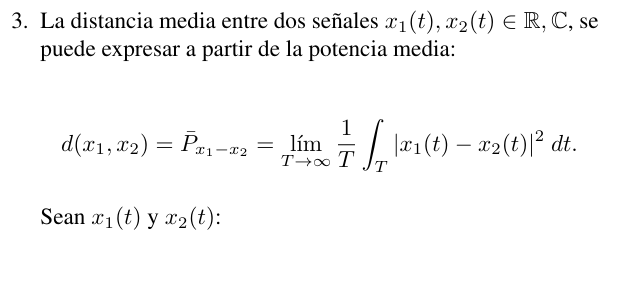

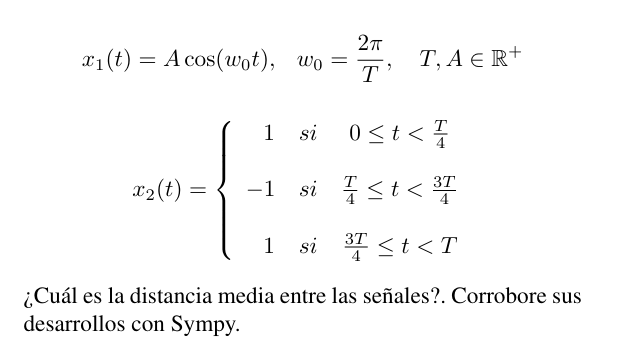

In [26]:
# %% [markdown]
# ### Punto 3: Cálculo Analítico de la Distancia Media entre Dos Señales Usando SymPy
#
# Este apartado utiliza la biblioteca SymPy para realizar el cálculo simbólico de la distancia media entre las dos señales dadas: una señal cosenoidal $x_1(t)$ y una señal rectangular periódica $x_2(t)$.
#
# **Definición de Distancia Media Cuadrática (Potencia Media de la Diferencia):**
# La potencia media de la diferencia entre dos señales periódicas con el mismo período $T$ se define como:
# $\bar{P}_{x_1 - x_2} = \frac{1}{T} \int_{0}^{T} |x_1(t) - x_2(t)|^2 dt$
#
# **Definición de Distancia Media:**
# La distancia media es la raíz cuadrada de la potencia media de la diferencia:
# $d(x_1, x_2) = \sqrt{\bar{P}_{x_1 - x_2}}$
#
# **Señales Dadas:**
# $x_1(t) = A\cos(w_0t)$, donde $w_0 = \frac{2\pi}{T}$, y $T, A \in \mathbb{R}^+$
#
# $x_2(t)$ es una señal periódica con período $T$, definida dentro de un período $[0, T)$ como:
# $x_2(t) = \begin{cases} 1 & \text{si } 0 \le t < T/4 \\ -1 & \text{si } T/4 \le t < 3T/4 \\ 1 & \text{si } 3T/4 \le t < T \end{cases}$

# %% [markdown]
# ## 1. Configuración Inicial: Importar Librerías y Definir Símbolos
#
# Importamos la librería SymPy y definimos las variables simbólicas necesarias para el cálculo analítico.
# %%
# Definición de variables simbólicas
A, t, T = sp.symbols('A t T', real=True, positive=True)  # A: Amplitud, t: tiempo, T: periodo
w0 = 2 * sp.pi / T  # Frecuencia angular fundamental (omega_0 = 2π / T)

print(f"Variables simbólicas definidas: A, t, T (reales y positivas)")
print(f"Frecuencia angular w0 calculada: {w0}")

# %% [markdown]
# ## 2. Definición Simbólica de las Señales
#
# Representamos las funciones matemáticas de las señales $x_1(t)$ y $x_2(t)$ utilizando las variables simbólicas definidas.
# %%
# Señal x1: señal cosenoidal de frecuencia fundamental w0
x1 = A * sp.cos(w0 * t)

# Señal x2: señal por tramos tipo onda cuadrada, definida en un periodo [0, T)
# Utilizamos sp.Piecewise para definir la función por intervalos.
x2 = sp.Piecewise(
    (1, (t >= 0) & (t < T/4)),             # Primer cuarto del periodo: valor 1
    (-1, (t >= T/4) & (t < 3*T/4)),        # Mitad central del periodo: valor -1
    (1, (t >= 3*T/4) & (t < T))            # Último cuarto del periodo: valor 1
)
# Nota: Aunque definimos x2 aquí, para la integración por tramos usaremos
# el valor constante de x2 en cada intervalo directamente en el integrando.

print(f"Señal x1(t) definida simbólicamente: {x1}")
print(f"Señal x2(t) definida simbólicamente por tramos: \n{x2}")

# %% [markdown]
# ## 3. Cálculo del Integrando: Cuadrado de la Diferencia (Definición General)
#
# Definimos la forma general del integrando, el cuadrado de la diferencia entre las dos señales.
# %%
# Definimos la forma general del integrando: (x1 - x2)^2
# Aunque para la integración real usaremos el valor específico de x2 en cada tramo.
integrando_general = (x1 - x2)**2

print(f"Forma general de la función integrando: (x1(t) - x2(t))^2")
# No imprimimos la forma expandida porque puede ser muy larga debido a Piecewise.

# %% [markdown]
# ## 4. Cálculo de la Integral Definida sobre un Período (Estrategia Alternativa Robusta)
#
# Calculamos la integral de la diferencia al cuadrado sobre un solo período [0, T) dividiéndola en los intervalos donde $x_2(t)$ es constante. Para evitar posibles problemas con `Piecewise` en los límites de integración, definimos el integrando específicamente para cada tramo utilizando el valor constante de $x_2(t)$ en ese intervalo.
# %%
# Calculamos la integral del integrando sobre un período [0, T).
# Definimos el integrando para cada tramo usando el valor constante de x2(t) en ese intervalo.

print("Calculando la integral simbólica sobre cada tramo del período con integrando específico:")

# --- Tramo 1: [0, T/4) ---
# En este tramo, x2(t) = 1. El integrando es (x1(t) - 1)^2.
integrando_tramo1 = (x1 - 1)**2
print(f"Integrando para el tramo 1 [0, T/4): {integrando_tramo1}")
integral_tramo1 = sp.integrate(integrando_tramo1, (t, 0, T/4))
print(f"Integral del tramo 1 [0, T/4): {integral_tramo1}")

# --- Tramo 2: [T/4, 3T/4) ---
# En este tramo, x2(t) = -1. El integrando es (x1(t) - (-1))^2 = (x1(t) + 1)^2.
integrando_tramo2 = (x1 + 1)**2
print(f"\nIntegrando para el tramo 2 [T/4, 3T/4): {integrando_tramo2}")
integral_tramo2 = sp.integrate(integrando_tramo2, (t, T/4, 3*T/4))
print(f"Integral del tramo 2 [T/4, 3T/4): {integral_tramo2}")

# --- Tramo 3: [3T/4, T) ---
# En este tramo, x2(t) = 1. El integrando es (x1(t) - 1)^2.
integrando_tramo3 = (x1 - 1)**2
print(f"\nIntegrando para el tramo 3 [3T/4, T): {integrando_tramo3}")
integral_tramo3 = sp.integrate(integrando_tramo3, (t, 3*T/4, T))
print(f"Integral del tramo 3 [3T/4, T): {integral_tramo3}")

# Sumamos las integrales de los tramos para obtener la integral total sobre el período.
integral_total_periodo = integral_tramo1 + integral_tramo2 + integral_tramo3

print(f"\nIntegral total de (x1(t) - x2(t))^2 sobre un período [0, T): {integral_total_periodo}")

# %% [markdown]
# ## 5. Cálculo de la Potencia Media (Distancia Media Cuadrática)
#
# La potencia media es el resultado de la integral total sobre un período, dividido por la duración del período $T$. Este valor representa la energía promedio por unidad de tiempo de la diferencia entre las señales, o la distancia media cuadrática al cuadrado.
# %%
# La potencia media es la integral total dividida por el período T.
potencia_media = integral_total_periodo / T

print(f"Potencia Media (Distancia Media Cuadrática al cuadrado) antes de simplificar: {potencia_media}")

# %% [markdown]
# ## 6. Simplificación de la Expresión de la Potencia Media
#
# Simplificamos la expresión simbólica obtenida para la potencia media para obtener una forma más concisa y final.
# %%
# Simplificamos la expresión de la potencia media.
# SymPy utiliza algoritmos para simplificar expresiones algebraicas.
potencia_media_simplificada = sp.simplify(potencia_media)

print(f"Potencia Media Simplificada: {potencia_media_simplificada}")

# %% [markdown]
# ## 7. Cálculo de la Distancia Media
#
# La distancia media entre las dos señales es la raíz cuadrada de la potencia media (la raíz cuadrada de la distancia media cuadrática al cuadrado).
# %%
# La distancia media es la raíz cuadrada de la potencia media simplificada.
distancia_media = sp.sqrt(potencia_media_simplificada)

print(f"Distancia Media Final: {distancia_media}")

# %% [markdown]
# ## 8. Verificación Numérica (Opcional)
#
# Sustituimos valores específicos de A y T en la expresión analítica de la distancia media obtenida para comparar con resultados de simulaciones numéricas si se realizaron previamente.
# %%
# Definimos valores de ejemplo para A y T.
A_ejemplo = 2.0
T_ejemplo = 1.0 # El resultado final de la distancia media no depende de T, pero lo incluimos en la sustitución.

# Sustituimos estos valores en la expresión simbólica de la distancia media.
# .subs() se usa para sustituir símbolos por valores.
# .evalf() se usa para obtener un valor numérico de la expresión simbólica.
distancia_media_numerica_sympy = distancia_media.subs({A: A_ejemplo, T: T_ejemplo}).evalf()

print(f"Distancia media para A={A_ejemplo}, T={T_ejemplo} (evaluada desde la expresión simbólica): {distancia_media_numerica_sympy:.4f}")

# Si tienes un resultado numérico previo de otra simulación (por ejemplo, usando scipy.integrate),
# podrías compararlo aquí para verificar consistencia.
# Por ejemplo, si 'distancia_media_numerica_prev' fuera el resultado numérico:
# print(f"Distancia media numérica previa: {distancia_media_numerica_prev:.4f}")
# print(f"Diferencia absoluta: {abs(distancia_media_numerica_sympy - distancia_media_numerica_prev):.4e}")

Variables simbólicas definidas: A, t, T (reales y positivas)
Frecuencia angular w0 calculada: 2*pi/T
Señal x1(t) definida simbólicamente: A*cos(2*pi*t/T)
Señal x2(t) definida simbólicamente por tramos: 
Piecewise((1, t < T/4), (-1, t < 3*T/4), (1, T > t))
Forma general de la función integrando: (x1(t) - x2(t))^2
Calculando la integral simbólica sobre cada tramo del período con integrando específico:
Integrando para el tramo 1 [0, T/4): (A*cos(2*pi*t/T) - 1)**2
Integral del tramo 1 [0, T/4): A**2*T/8 - A*T/pi + T/4

Integrando para el tramo 2 [T/4, 3T/4): (A*cos(2*pi*t/T) + 1)**2
Integral del tramo 2 [T/4, 3T/4): A**2*T/4 - 2*A*T/pi + T/2

Integrando para el tramo 3 [3T/4, T): (A*cos(2*pi*t/T) - 1)**2
Integral del tramo 3 [3T/4, T): A**2*T/8 - A*T/pi + T/4

Integral total de (x1(t) - x2(t))^2 sobre un período [0, T): A**2*T/2 - 4*A*T/pi + T
Potencia Media (Distancia Media Cuadrática al cuadrado) antes de simplificar: (A**2*T/2 - 4*A*T/pi + T)/T
Potencia Media Simplificada: A**2/2 - 4*A/

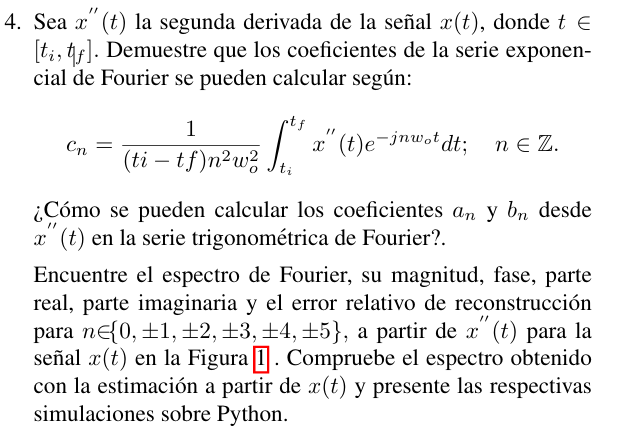

In [ ]:
from ipywidgets import interact,IntSlider  # Para crear controles interactivos
 #(no usados aún)
A=1 # Amplitud de la señal (no se usa en este bloque, pero está definido)
d2=2
d1=1
#mostrar la señal
T = 2*d2 # segundos de gráfica
Fo = 1/T # Extremo derecho del trapecio
Fs = 1000*Fo # frecuencia de muestreo definida
tv = np.arange(-T/2,T/2,1/Fs) #vector de tiempo generado
Nm = len(tv) #numero de muestras requeridas
def funcion_trapecio(x, a, b, c, d):
    """
    Genera una función en forma de trapecio.

    Parámetros:
    - x: Un array de valores en el eje x.
    - a: Inicio de la pendiente ascendente.
    - b: Inicio de la meseta (valores altos constantes).
    - c: Fin de la meseta (valores altos constantes).
    - d: Fin de la pendiente descendente.

    Retorna:
    - Un array con los valores de la función trapezoidal en cada punto x.
    """
    """
    Devuelve una señal trapezoidal con:
    - Subida entre a y b
    - Meseta entre b y c
    - Bajada entre c y d
    - Valor cero fuera del rango [a, d]
    """
    return np.maximum(0, np.minimum((x - a) / (b - a), np.minimum(1, (d - x) / (d - c))))

# Ejemplo de uso
x = funcion_trapecio(tv, -d2, -d1, d1, d2)  # Aplica la función trapezoidal
 #sobre el eje de tiempo



#graficar señal original
plt.plot(tv,x,'r',linewidth=4)  # Dibuja la señal en rojo
plt.grid()  # Activa la cuadrícula
plt.xlabel("t[s]",fontsize = 14) # Etiqueta del eje X
plt.ylabel("x(t)",fontsize = 14) # Etiqueta del eje Y
plt.show()   # Muestra el gráfico

In [ ]:
N = 5 #numero armonicos
wo = 2*np.pi/T # frecuencia fundamental
# definir bases
phin = np.zeros((Nm,2*N+1),np.complex128)#crear matriz para guardar bases
for n in range(-N,N+1,1):
    phin[:,n+N] = np.exp(1j*n*wo*tv)#base de fourier en el intervalo de interés

#calcular espectro -> cambiar según la señal estudiada
cn = np.zeros(2*N+1,np.complex128)
nv = np.linspace(-N, N, 2*N+1) #vector num armónicos
Cn = (-2*(np.cos(nv*np.pi)-np.cos(nv*np.pi*0.5)))/(np.pi**2*nv**2)
Cn[N] = 3/4 #Nivel DC

In [ ]:
#graficar espectro
fig = plt.figure(figsize=(8,8)) # Crear figura de 8x8 pulgadas
plt.subplot(2,2,1)  # Primer subplot (fila 1, col 1)
plt.stem(nv, np.real(Cn), 'r')  # Gráfico de líneas y puntos (color rojo)
plt.xlabel(r'$nw_o$[rad/s]', fontsize=14)  # Etiqueta eje X
plt.ylabel(r'$Re\{C_n\}$', fontsize=14)    # Etiqueta eje Y
plt.axis('tight')  # Ajustar ejes a los datos
plt.grid()         # Activar cuadrícula

plt.subplot(2,2,2)
plt.stem(nv, np.imag(Cn), 'r')
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$Im\{C_n\}$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,2,3)
plt.stem(nv, abs(Cn), 'r')#magnitud del espectro
plt.xlabel(r'$nw_o$[rad/s]',fontsize = 14)
plt.ylabel(r'$|C_n|$',fontsize = 14)
plt.axis('tight')
plt.grid()

plt.subplot(2,2,4)  # Cuarto subplot (fila 2, col 2)
plt.stem(nv, np.angle(Cn), 'r')  # Fase en radianes
plt.xlabel(r'$nw_o$[rad/s]', fontsize=14)
plt.ylabel(r'$\langle C_n$', fontsize=14)
plt.axis('tight')
plt.grid()

fig.tight_layout() # Optimiza el espacio entre gráficos